In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.data_loader import load_and_align_prices
from src.validation import run_walk_forward
from src.monte_carlo import monte_carlo_simulation

from pathlib import Path

fig_dir = Path("../results/figures")
fig_dir.mkdir(parents=True, exist_ok=True)


In [4]:
prices = load_and_align_prices(
    "../data/gold.csv",
    "../data/silver.csv"
)


In [5]:
with open("../results/statistical_summary.json", "r") as f:
    stats = json.load(f)

hedge_ratio = stats["hedge_ratio"]
half_life = int(stats["half_life_days"])

hedge_ratio, half_life

(0.8398666970367117, 69)

In [6]:
wf_results = run_walk_forward(
    prices=prices,
    hedge_ratio=hedge_ratio,
    z_window=half_life,
    entry_z=2.0,
    exit_z=0.5,
    max_z=3.0,
    transaction_cost=0.0001,
    periods_per_year=252
)

wf_results


/Users/tanmaygarg/Desktop/gold_silver_strategy/src/strategy.py:46: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  position = signal.replace(to_replace=0, method="ffill")
/Users/tanmaygarg/Desktop/gold_silver_strategy/src/strategy.py:46: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  position = signal.replace(to_replace=0, method="ffill")


{'in_sample': {'metrics': {'Total Return': np.float64(0.26282933011922105),
   'Annualized Return': np.float64(0.03478034538969377),
   'Sharpe Ratio': np.float64(0.29136459223453637),
   'Max Drawdown': np.float64(-0.2861960587231922),
   'Calmar Ratio': np.float64(0.12152629056060199)},
  'returns': timestamp
  2015-01-05 00:00:00+05:30   -0.000000
  2015-01-06 00:00:00+05:30   -0.000000
  2015-01-07 00:00:00+05:30   -0.000000
  2015-01-08 00:00:00+05:30    0.000000
  2015-01-09 00:00:00+05:30    0.000000
                                 ...   
  2021-09-14 00:00:00+05:30   -0.001694
  2021-09-15 00:00:00+05:30    0.001536
  2021-09-16 00:00:00+05:30   -0.005719
  2021-09-17 00:00:00+05:30   -0.006588
  2021-09-20 00:00:00+05:30   -0.005659
  Name: strategy_return, Length: 1720, dtype: float64},
 'out_of_sample': {'metrics': {'Total Return': np.float64(0.23928873364834868),
   'Annualized Return': np.float64(0.07611372068375455),
   'Sharpe Ratio': np.float64(0.5919431902184666),
   

In [7]:
in_sharpe = wf_results["in_sample"]["metrics"]["Sharpe Ratio"]
out_sharpe = wf_results["out_of_sample"]["metrics"]["Sharpe Ratio"]

in_sharpe, out_sharpe


(np.float64(0.29136459223453637), np.float64(0.5919431902184666))

In [8]:
oos_returns = wf_results["out_of_sample"]["returns"]

mc = monte_carlo_simulation(
    oos_returns,
    num_simulations=1000
)


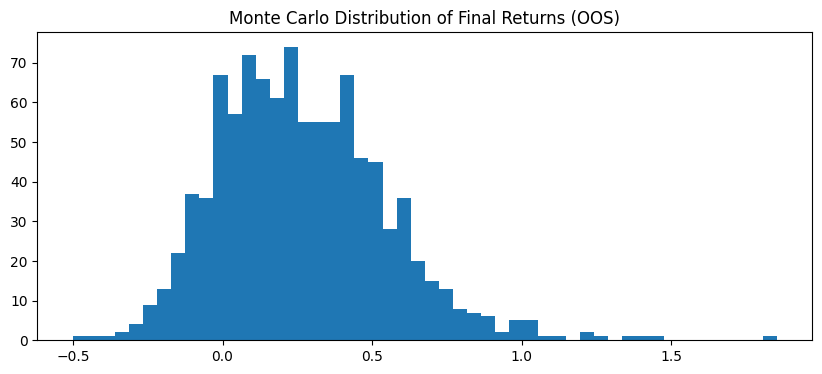

In [9]:
plt.figure(figsize=(10, 4))
plt.hist(mc["final_returns"], bins=50)
plt.title("Monte Carlo Distribution of Final Returns (OOS)")

plt.savefig(
    fig_dir / "monte_carlo_final_returns.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


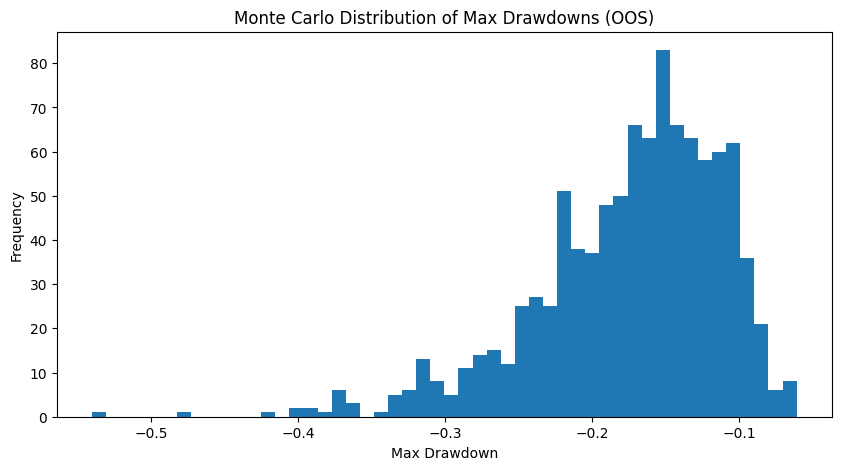

In [10]:
plt.figure(figsize=(10, 5))
plt.hist(mc["max_drawdowns"], bins=50)
plt.title("Monte Carlo Distribution of Max Drawdowns (OOS)")
plt.xlabel("Max Drawdown")
plt.ylabel("Frequency")

plt.savefig(
    fig_dir / "monte_carlo_drawdowns.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


In [11]:
drawdowns = mc["max_drawdowns"]

prob_dd_20 = (drawdowns < -0.20).mean()
prob_dd_20


np.float64(0.29)

In [ ]:
from pathlib import Path
import json
import numpy as np

validation_summary = {
    "in_sample": wf_results["in_sample"]["metrics"],
    "out_of_sample": wf_results["out_of_sample"]["metrics"],
    "sharpe_ratio_check": {
        "in_sample_sharpe": float(in_sharpe),
        "out_of_sample_sharpe": float(out_sharpe),
        "oos_to_is_ratio": float(out_sharpe / in_sharpe)
    },
    "monte_carlo": {
        "median_final_return": float(np.median(mc["final_returns"])),
        "p05_final_return": float(np.percentile(mc["final_returns"], 5)),
        "p95_final_return": float(np.percentile(mc["final_returns"], 95)),
        "probability_dd_gt_20pct": float(prob_dd_20)
    }
}

output_dir = Path("../results/validation")
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / "validation_summary.json", "w") as f:
    json.dump(validation_summary, f, indent=4)

validation_summary
